# Phase 2 - Muliticlass classifier to predict death time for in-hospital mortality

We propose to a two-phase model framework to predict in-hospital mortality and death time in hours. This notebook presents the machine learning pipeline for model training, hyperparameter tuning and model evaluation in Phase 2. In Phase 2, a multiclass classifier was trained to predict death time in hours since ICU admission using the same set of extracted features in Phase 1 (i.e. the 123 features extracted from the previous stage of feature engineering in Hive). 

* Part 1. Define classes and methods for the machine learning pipieline
* Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data
* Part 3. Visualization of ROC curves
* Part 4. Visualization of feature importance

In [1]:
import pandas as pd
import numpy as np
# from scipy import interp  # Removed, use np.interp instead
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import sklearn.multiclass
from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt
from utils import connect_db
from pathlib import Path
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 12})
import joblib

---
## Part 1. Define classes and methods for the machine learning pipieline

Similar to Phase 1, we first define the classes of `CustomLabelBinarizer`, `ItemSelector` and `MultiItemSelector` for custom data transformation in sklearn pipieline. Specifically,

* `CustomLabelBinarizer` converts multi-class labels to binary labels.
* `ItemSelector` and `MultiItemSelector` select custom features from the input dataframe.

In [2]:
unseen_label = "__New__"
seed = 200

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.le = LabelEncoder()
        self.lb = LabelBinarizer()
        self.seen_labels = set()
        
    def fit(self, x, y=None,**fit_params):
        self.seen_labels = set(x)
        self.seen_labels.add(unseen_label)
        
        # add "unseen" to X
        x_new = list(x)
        x_new.append(unseen_label)

        label_encoded = self.le.fit_transform(x_new)
        self.lb.fit(label_encoded)
        return self
    
    def transform(self, x):
        x_new = list(map(lambda label: label if label in self.seen_labels else unseen_label, list(x)))
        label_encoded = self.le.transform(x_new)
        return self.lb.transform(label_encoded)
    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

    
class MultiItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key_list):
        self.key_list = key_list

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key_list]

Next, we define two useful methods `descretize()` and `evaluate()` for data transformation and model evaluation. Note that `hosp_deathtime_hours` is the death time in hours since ICU admission. We will train classifiers to predict the multiclass labels based on this variable.

* `descretize()` transforms numerical values into multiclass labels {0,1,2} with cutoff parameters.
* `evaluate()` evaluates the model performance and prints a detailed report of the performance metrics e.g. accuracy, AUC score, precision, recall and F1 score.

In [3]:
def descretize(x, cutoff1, cutoff2):
    if x < cutoff1:
        return 0
    elif x < cutoff2:
        return 1
    else: 
        return 2

def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1score_micro = f1_score(y_true, y_pred, average='micro')   
    f1score_macro = f1_score(y_true, y_pred, average='macro')  
    print ("Accuracy : {:.4f}".format(acc))
    print("Precision (Micro) : {:.4f}".format(precision_micro))
    print("Precision (Macro): {:.4f}".format(precision_macro))
    print("Recall (Micro) : {:.4f}".format(recall_micro))
    print("Recall (Macro): {:.4f}".format(recall_macro))
    print("F1 score (Micro) : {:.4f}".format(f1score_micro))
    print("F1 score (Macro): {:.4f}".format(f1score_macro))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

Now, we are ready to define the main method `train_evaluate_model`. The method does the following:

* Filter out the ICU stays with negative death time since ICU admission (which is likely an administrative error resulting in an incorrect ICU admission or incorrect death time)
* Split data into 80% training set and 20% test set
* Build custom machine learning pipeline which 
    * select specified features from the input dataframe (`ItemSelector` and `MultiItemSelector`) 
    * transform categorical data into binary label (`CustomLabelBinarizer`) 
    * impute missing values for numerical data with median (`Imputer`)
    * train `RandomForestClassifier` using `GridSearchCV` on 5-fold CV of the training set
    * find the best parameter set from the grid search
* Evaluate the model performance using the best parameter set on the test set

Note that we also transform the numerical values of `hosp_deathtime_hours` to the following 3 classes using `descretize()` and then fit the pipeline to predict the multiclass labels.

* Class 0 : hosp_deathtime_hours < 24 hours
* Class 1 : 24 hours <= hosp_deathtime_hours < 24 * 7 hours
* Class 2 : hosp_deathtime_hours >= 24 * 7 hours

In [4]:
def train_evaluate_model(df):
    # set cutoff for multiclass labels
    cutoff1 = 24
    cutoff2 = 24*7
    
    # filter out ICU stays with negative death time
    # so that our model will train on dead patients with death time >= 0
    df_dead = df[(df.hospital_expire_flag==1) & (df.hosp_deathtime_hours>=0)]
    print(df.shape, df_dead.shape)
    
    # split data into 80% training set, 20% test set
    train_cv_df = df_dead.sample(frac=0.8,random_state=seed)
    test_df = df_dead.drop(train_cv_df.index)
    print('Train-test split: ', train_cv_df.shape, test_df.shape)
    
    # define the machine learning pipeline
    discrete_pipeline = Pipeline([
        ("feature_union", FeatureUnion(
            transformer_list=[
                # categorical pipeline
                ('ethnicity', Pipeline([
                    ("selector", ItemSelector(key='ethnicity')),
                    ("binarizer", CustomLabelBinarizer())
                ])),            

                ("gender", Pipeline([
                    ("selector", ItemSelector(key='gender')),
                    ("binarizer", CustomLabelBinarizer())
                ])),
                ("admission_type", Pipeline([
                    ("selector", ItemSelector(key='admission_type')),
                    ("binarizer", CustomLabelBinarizer())
                ])),

                # numerical pipeline
                ("numerical", Pipeline([
                    ("selector", MultiItemSelector(key_list=
                          ['age', 'icustay_num',
                           'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                           'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                           'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                           'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                           'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                           'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                           'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                           'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                           'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                           'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                           'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                           'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                           'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                           'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                           'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                           'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                           'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                           'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                           'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                           'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                           'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                           'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                           'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                           'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                           'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                           'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                           'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                           'urineoutput'])),
                    # impute missing values with median
                    ("imputer", SimpleImputer(strategy="median",)),
                ]))

            ]
        )),
        ("algorithm", RandomForestClassifier(n_jobs=-1))
    ])

    # define the parameter grid
    parameters = {'algorithm__n_estimators': [100, 250, 500],
                  'algorithm__max_features': ["auto", "sqrt", "log2"],
                  "algorithm__criterion": ["gini", "entropy"],
                  "algorithm__max_depth": [5, 10, 30],
                  "algorithm__bootstrap": [True, False]}

    # grid search on 5-fold CV, trained on 80% training set
    # note that we have also transformed hosp_deathtime_hours to 3 classes using descretize()
    grid_search = GridSearchCV(discrete_pipeline, parameters, n_jobs=-1, verbose=1, refit=True, cv=5, scoring='f1_micro')
    grid_search.fit(train_cv_df, train_cv_df.hosp_deathtime_hours.map(lambda x: descretize(x, cutoff1, cutoff2)))

    # retrieve the best parameter set from grid search
    print("\nGrid Search Best parameters set :")
    print(grid_search.best_params_)
    print("\nBest score: %0.3f" % grid_search.best_score_)
    
    # print test score on each fit
#     print("\nGrid scores :")
#     means = grid_search.cv_results_['mean_test_score']
#     stds = grid_search.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds,grid_search.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    
    # evaluate model performance
    print("\nEvaluation on Test Set (20%) :")
    test_actual = test_df.hosp_deathtime_hours.map(lambda x: descretize(x, cutoff1, cutoff2))
    test_pred = grid_search.predict(test_df)
    evaluate(test_actual, test_pred)
    
    # compute prediction proba (y_score) and actual label (y_test) on test set
    # they will be used for plotting ROC curves later
    ohc = OneHotEncoder()
    y_test = ohc.fit_transform(test_actual.values.reshape(-1,1)).todense()
    y_score = grid_search.predict_proba(test_df)
    print(y_test.shape, y_score.shape)
    
    return grid_search, y_test, y_score

---
## Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data
Now we have defined our custom machine learning pipeline, we are ready to fit the 6-hour, 12-hour and 24-hour data to the pipeline respectively.

In [5]:
# load 6-hour, 12-hour and 24-hour data extracted previously using Hive
#df_6hr = pd.read_csv('../data/mp_data_6hr.csv')
#df_12hr = pd.read_csv('../data/mp_data_12hr.csv')
#df_24hr = pd.read_csv('../data/mp_data_24hr.csv')

query = """select * from mp_data_6hr"""
df_6hr = connect_db(query)
query = """select * from mp_data_12hr"""
df_12hr = connect_db(query)
query = """select * from mp_data_24hr"""
df_24hr = connect_db(query)

print(df_6hr.shape, df_12hr.shape, df_24hr.shape)
df_6hr.head()

/Users/debduttaguharoy/Developer/Y2 - Master's Thesis/Usecases/Predicting-Death-Time-and-Mortality/Model/Code/Notebooks/utils.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, con=con)


(49632, 131) (49632, 131) (49632, 131)


,subject_id,hadm_id,icustay_id,dbsource,expire_flag,hospital_expire_flag,deathtime_hours,hosp_deathtime_hours,age,gender,...,hemoglobin_max,lactate_max,platelet_max,potassium_max,ptt_max,inr_max,sodium_max,bun_max,wbc_max,urineoutput
0,3,145834,211552,carevue,1,0,5669.0,NaN,76.5246,M,...,10.1,8.0,221.5,4.05,52.35,1.7,141.5,42.0,15.2,20.0
1,4,185777,294638,carevue,0,0,NaN,NaN,47.8450,F,...,10.6,NaN,201.0,3.30,33.20,1.1,141.0,10.0,9.7,550.0
2,6,107064,228232,carevue,0,0,NaN,NaN,65.9398,F,...,9.2,NaN,330.0,4.80,41.20,1.1,134.0,65.0,10.6,760.0
3,9,150750,220597,carevue,1,1,107.0,118.0,41.7887,M,...,14.0,1.9,NaN,2.90,NaN,NaN,138.0,NaN,NaN,1450.0
4,11,194540,229441,carevue,1,0,5082.0,NaN,50.1476,F,...,12.6,NaN,258.0,3.90,NaN,NaN,141.0,14.0,9.3,400.0


In [6]:
# fit the pipeline using 6-hour data
grid_search_6hr, y_test_6hr, y_score_6hr = train_evaluate_model(df_6hr)
joblib.dump(grid_search_6hr, "phase2_gridsearch_6h.pkl")

(49632, 131) (5718, 131)
Train-test split:  (4574, 131) (1144, 131)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin


Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 500}

Best score: 0.544

Evaluation on Test Set (20%) :
Accuracy : 0.5367
Precision (Micro) : 0.5367
Precision (Macro): 0.5745
Recall (Micro) : 0.5367
Recall (Macro): 0.4944
F1 score (Micro) : 0.5367
F1 score (Macro): 0.5172

Classification report : 
               precision    recall  f1-score   support

           0       0.66      0.35      0.46       157
           1       0.48      0.57      0.52       486
           2       0.58      0.56      0.57       501

    accuracy                           0.54      1144
   macro avg       0.57      0.49      0.52      1144
weighted avg       0.55      0.54      0.53      1144


Confusion matrix : 
 [[ 55  81  21]
 [ 23 277 186]
 [  5 214 282]]
(1144, 3) (1144, 3)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin

['phase2_gridsearch_6h.pkl']

In [7]:
# fit the pipeline using 12-hour data
grid_search_12hr, y_test_12hr, y_score_12hr = train_evaluate_model(df_12hr)
joblib.dump(grid_search_12hr, "phase2_gridsearch_12h.pkl")

(49632, 131) (5718, 131)
Train-test split:  (4574, 131) (1144, 131)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin


Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 10, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 500}

Best score: 0.568

Evaluation on Test Set (20%) :
Accuracy : 0.5559
Precision (Micro) : 0.5559
Precision (Macro): 0.6202
Recall (Micro) : 0.5559
Recall (Macro): 0.5306
F1 score (Micro) : 0.5559
F1 score (Macro): 0.5593

Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.45      0.57       157
           1       0.49      0.54      0.52       486
           2       0.58      0.60      0.59       501

    accuracy                           0.56      1144
   macro avg       0.62      0.53      0.56      1144
weighted avg       0.57      0.56      0.56      1144


Confusion matrix : 
 [[ 70  75  12]
 [ 16 264 206]
 [  3 196 302]]
(1144, 3) (1144, 3)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin

['phase2_gridsearch_12h.pkl']

In [8]:
# fit the pipeline using 24-hour data
grid_search_124hr, y_test_24hr, y_score_24hr = train_evaluate_model(df_24hr)
joblib.dump(grid_search_124hr, "phase2_gridsearch_24h.pkl")

(49632, 131) (5718, 131)
Train-test split:  (4574, 131) (1144, 131)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin


Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 10, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Best score: 0.600

Evaluation on Test Set (20%) :
Accuracy : 0.5979
Precision (Micro) : 0.5979
Precision (Macro): 0.6744
Recall (Micro) : 0.5979
Recall (Macro): 0.5849
F1 score (Micro) : 0.5979
F1 score (Macro): 0.6159

Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.54      0.67       157
           1       0.53      0.59      0.56       486
           2       0.62      0.63      0.62       501

    accuracy                           0.60      1144
   macro avg       0.67      0.58      0.62      1144
weighted avg       0.62      0.60      0.60      1144


Confusion matrix : 
 [[ 85  67   5]
 [ 12 285 189]
 [  0 187 314]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin

(1144, 3) (1144, 3)


['phase2_gridsearch_24h.pkl']

---
## Part 3. Visualization of ROC curves

Next, we define `plot_roc()` to compute the following evaluation metrics and plot the ROC curves. Reference has been made to this [code](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) provided by sklearn.

* Micro-average ROC AUC
* Macro-average ROC AUC
* ROC AUC for Class 0
* ROC AUC for Class 1
* ROC AUC for Class 2

In [9]:
def plot_roc(y_test, y_score, plot_title, filepath) :
    
    # compute fpr, tpr and auc for each class respectively
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # compute micro-average fpr, tpr and auc
    fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_test).ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
   # compute macro-average fpr, tpr and auc
    n_classes = 3
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # plot all ROC curves
    lw = 2
    fig = plt.figure()
    fig.set_size_inches(8,7)
    plt.plot(fpr["micro"], tpr["micro"],\
             label='micro-average ROC curve (area = {0:0.2f})'\
             ''.format(roc_auc["micro"]),\
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],\
             label='macro-average ROC curve (area = {0:0.2f})'\
                   ''.format(roc_auc["macro"]),\
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,\
                 label='ROC curve of class {0} (area = {1:0.2f})'\
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="lower right")
    
    # Get the current working directory
    current_directory = Path.cwd()

    img_dir = current_directory / 'data' / 'Model' / 'Code' / 'Images'
    img_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
    filepath = img_dir / f'{plot_title}.png'
    fig.savefig(filepath)
    plt.show()

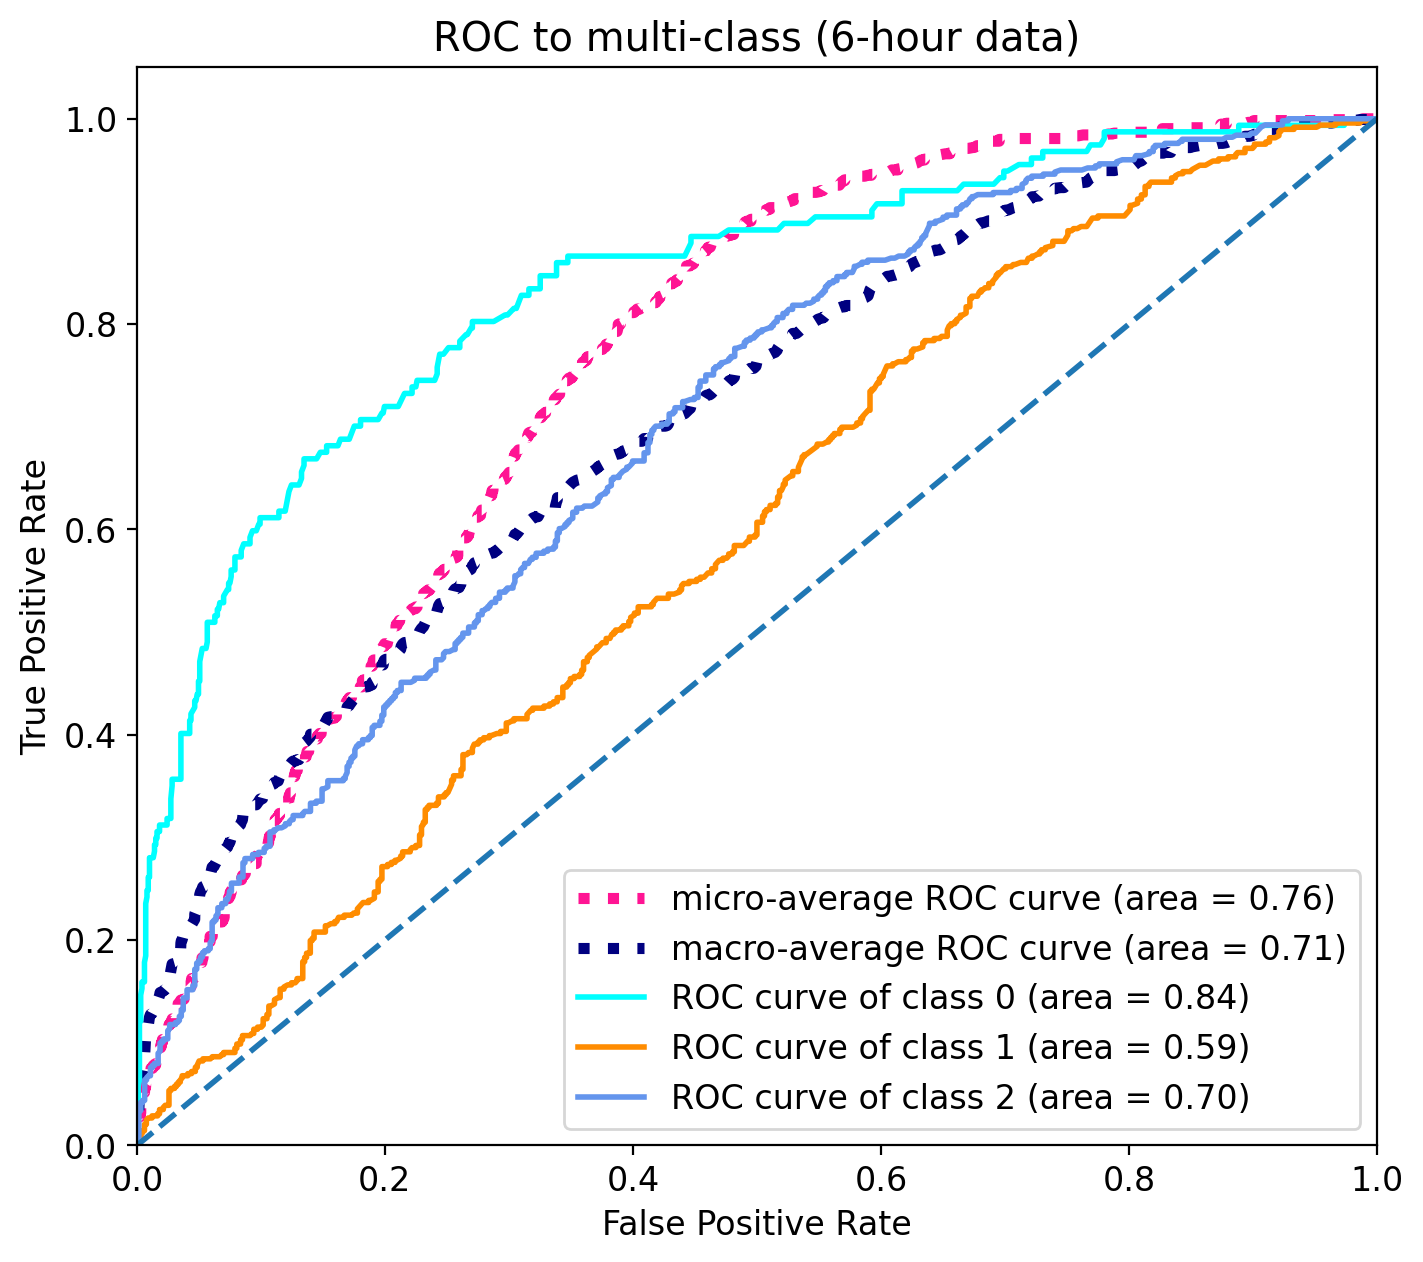

In [10]:
current_directory = Path.cwd()
img_dir = current_directory / 'data' / 'Model' / 'Code' / 'Images'
img_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

y_test=np.array(y_test_6hr)
y_score=np.array(y_score_6hr)
# plot ROC curves for 6-hour data
plot_roc(y_test, y_score, 
         plot_title='ROC to multi-class (6-hour data)', filepath=img_dir / 'ROC_6hr.png')

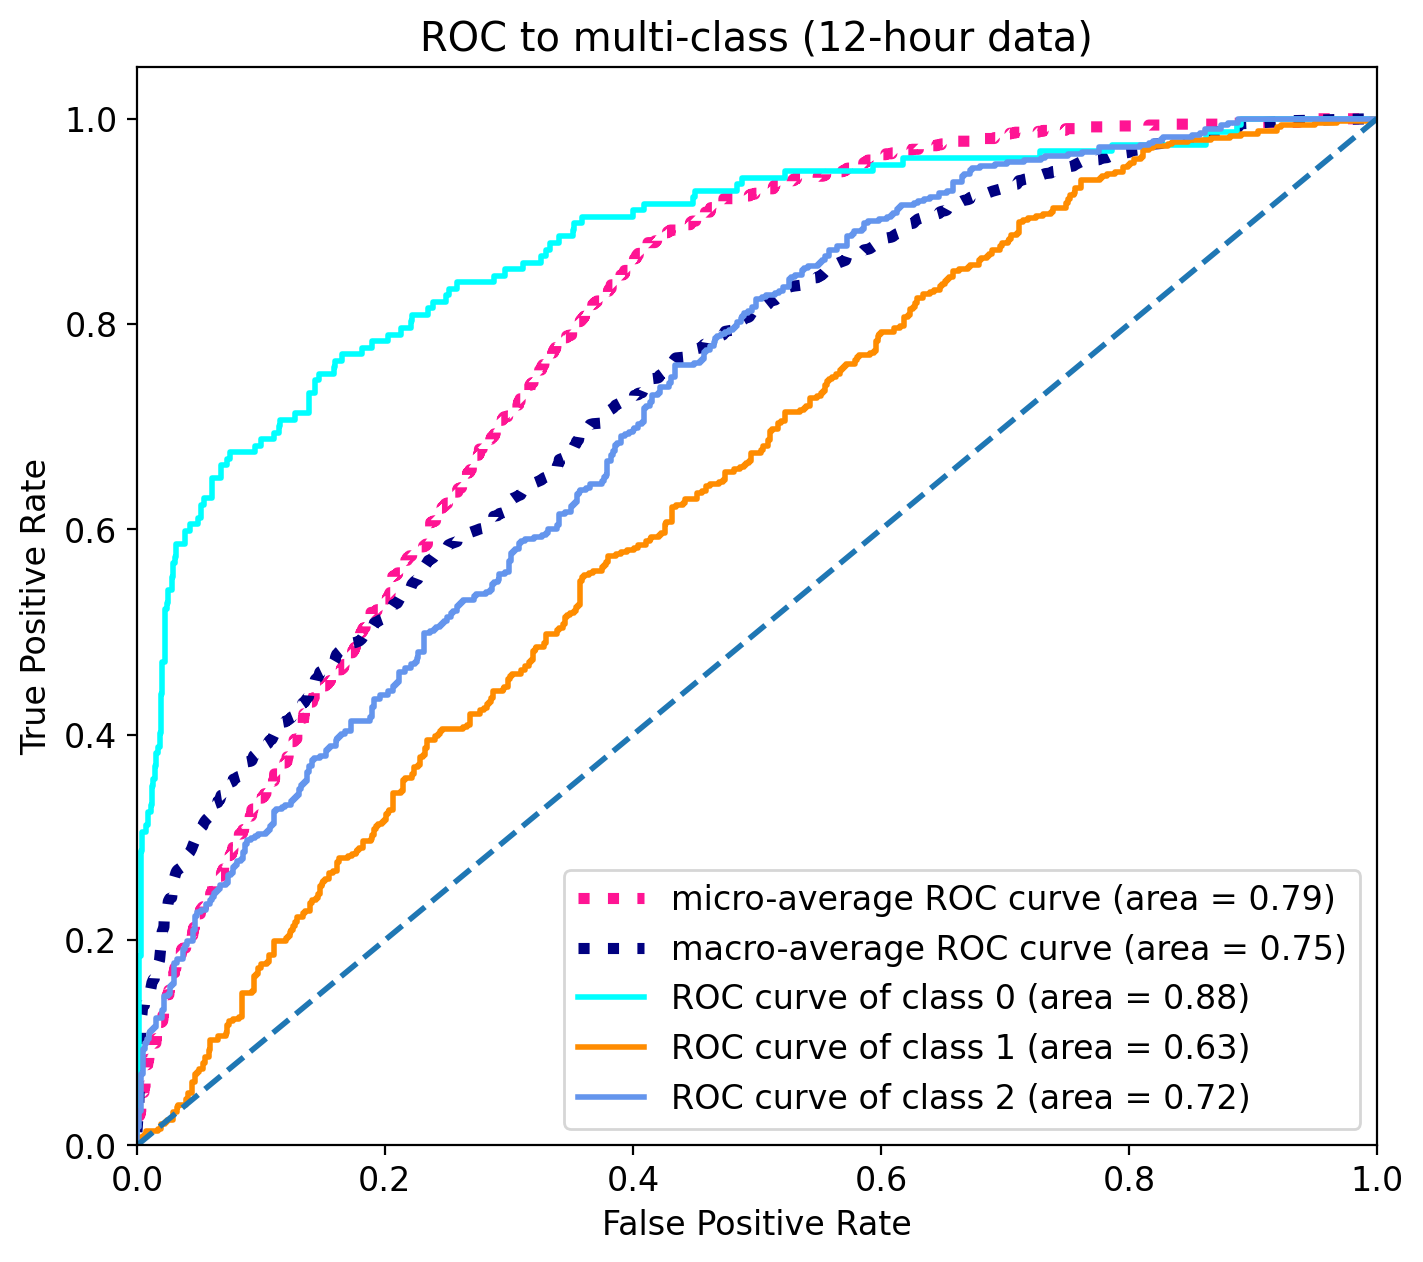

In [11]:
current_directory = Path.cwd()
img_dir = current_directory / 'data' / 'Model' / 'Code' / 'Images'
img_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

y_test=np.array(y_test_12hr)
y_score=np.array(y_score_12hr)
# plot ROC curves for 6-hour data
plot_roc(y_test, y_score, 
         plot_title='ROC to multi-class (12-hour data)', filepath=img_dir / 'ROC_12hr.png')

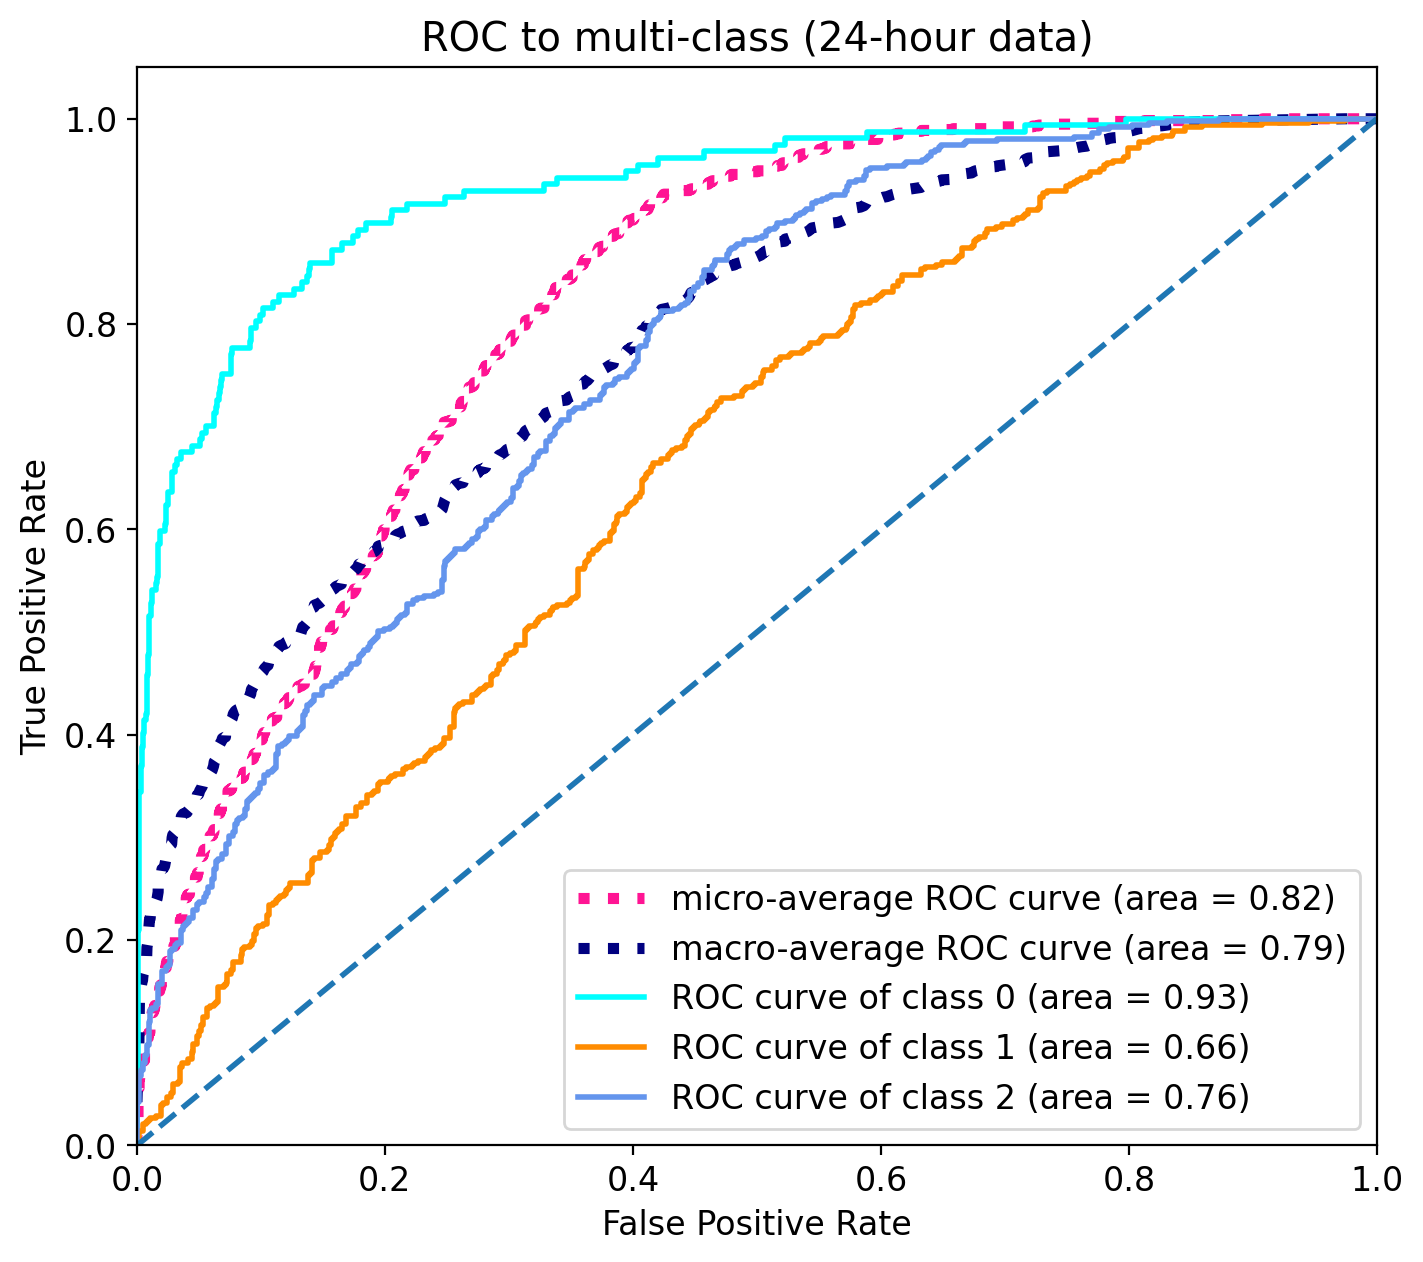

In [12]:
current_directory = Path.cwd()
img_dir = current_directory / 'data' / 'Model' / 'Code' / 'Images'
img_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

y_test=np.array(y_test_24hr)
y_score=np.array(y_score_24hr)
# plot ROC curves for 6-hour data
plot_roc(y_test, y_score,
         plot_title='ROC to multi-class (24-hour data)', filepath=img_dir / 'ROC_24hr.png')

---
## Part 4. Visualization of Feature Importance

* In this part, we want to dive deeper to visualize the feature importance of the random forest classifier trained on 6-hour ICU data. Let's us retrain the classifier with the best parameter set resulted from the grid search in Part 2, so that we can retreive the feature importance

In [13]:
# show best parameter resulted from grid search
grid_search_6hr.best_params_

{'algorithm__bootstrap': True,
 'algorithm__criterion': 'entropy',
 'algorithm__max_depth': 30,
 'algorithm__max_features': 'sqrt',
 'algorithm__n_estimators': 500}

In [14]:
# load data
#df_6hr = pd.read_csv('../data/mp_data_6hr.csv')
query = """select * from mp_data_6hr"""
df_6hr = connect_db(query)

# define features
categorical_features = ['gender', 'ethnicity', 'admission_type']
numerical_features = ['age', 'icustay_num',
                       'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                       'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                       'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                       'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                       'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                       'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                       'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                       'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                       'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                       'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                       'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                       'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                       'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                       'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                       'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                       'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                       'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                       'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                       'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                       'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                       'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                       'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                       'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                       'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                       'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                       'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                       'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                       'urineoutput']
features = categorical_features + numerical_features 

# impute missing values of numerical features with median
for col in numerical_features:
    df_6hr[col].fillna(df_6hr[col].median(), inplace=True)
    
# encoding categorical features
le_gender = LabelEncoder()
df_6hr['gender'] = le_gender.fit_transform(df_6hr.gender)
le_enthnicity = LabelEncoder()
df_6hr['ethnicity'] = le_enthnicity.fit_transform(df_6hr.ethnicity)
le_admission_type = LabelEncoder()
df_6hr['admission_type'] = le_admission_type.fit_transform(df_6hr.admission_type)

# train-test split
y = df_6hr.hosp_deathtime_hours.map(lambda x: descretize(x, cutoff1=24, cutoff2=24*7))                        
X = df_6hr[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# train classifier with the best paramter set
best_params = grid_search_6hr.best_params_

clf = RandomForestClassifier(n_estimators=best_params['algorithm__n_estimators'], 
                            max_features=best_params['algorithm__max_features'],
                            max_depth=best_params['algorithm__max_depth'],
                            bootstrap=best_params['algorithm__bootstrap'],
                            criterion=best_params['algorithm__criterion'],
                            random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
print("Accuracy score on training set and test set: ", clf.score(X_train, y_train), clf.score(X_test, y_test))

/Users/debduttaguharoy/Developer/Y2 - Master's Thesis/Usecases/Predicting-Death-Time-and-Mortality/Model/Code/Notebooks/utils.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, con=con)
/var/folders/qd/hxnw7jb56lb72yft16bm17c40000gn/T/ipykernel_26766/2789255237.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_6hr[col].fillna(df_6hr[col]

Accuracy score on training set and test set:  1.0 0.9390551022463988


Top 10 features
age              0.024945
resprate_mean    0.024520
urineoutput      0.024316
gcsmotor_max     0.022448
spo2_mean        0.021076
sysbp_min        0.020886
gcseyes_mean     0.020589
sysbp_mean       0.020213
tempc_mean       0.018174
resprate_min     0.018126
dtype: float64


<Axes: >

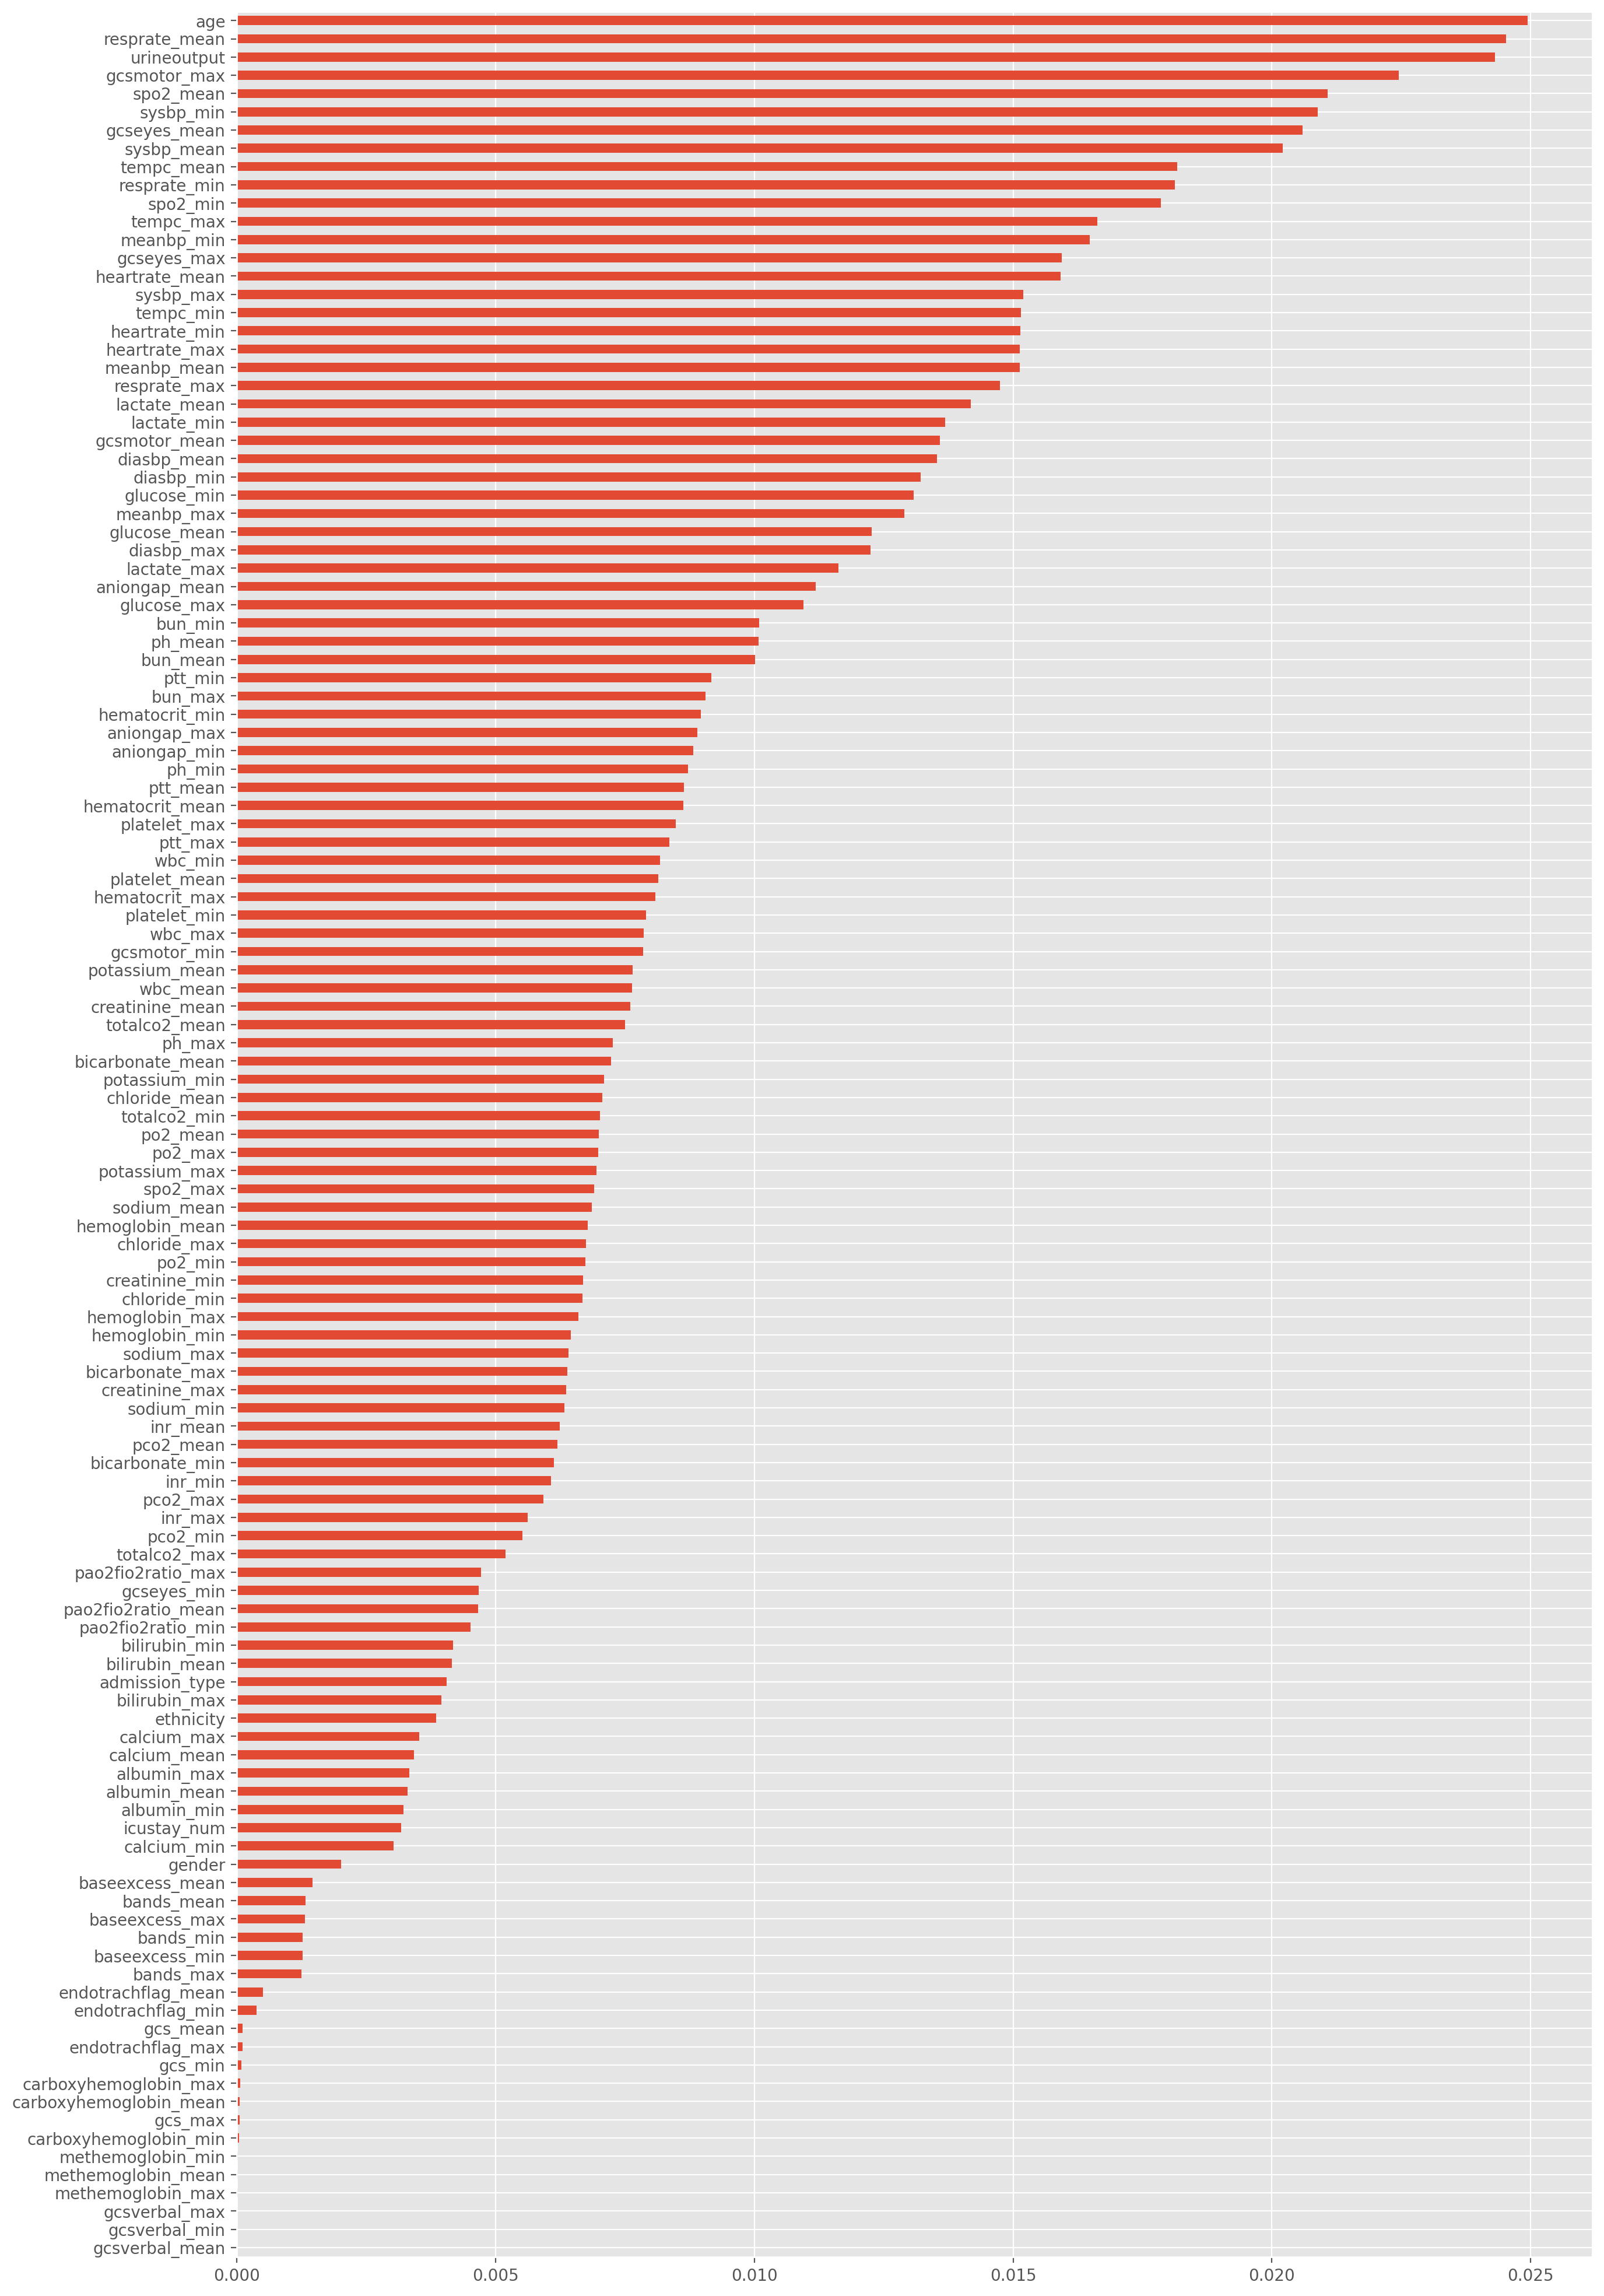

In [15]:
# plot feature importance
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(15,25)
    
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
print("Top 10 features")
print(feat_importances.nlargest(10))

feat_importances.nsmallest(123).plot(kind='barh')

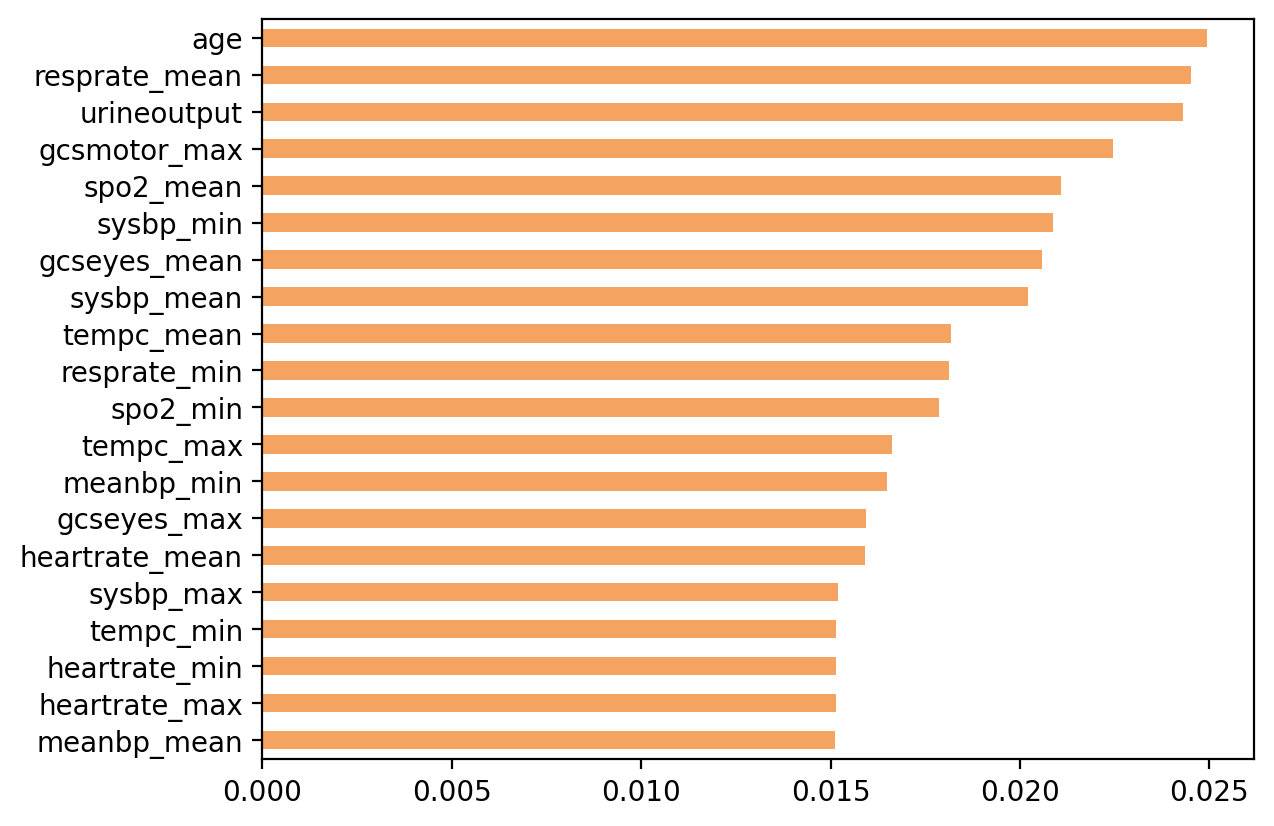

In [16]:
# plot top 20 feature importance
plt.style.use('default')
fig.set_size_inches(15,10)
fig = plt.figure()
feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh', color='sandybrown')
current_directory = Path.cwd()
img_dir = current_directory / 'data' / 'Model' / 'Code' / 'Images'
img_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
fig.savefig(img_dir, bbox_inches='tight', pad_inches=0.5)
plt.show()